# Лабораторная работа №5 «Решение уравнения переноса на плоскости по разностной схеме "Прямоугольник"»

## Дашкевич Артём Владимирович

### Скрин постановки задачи:
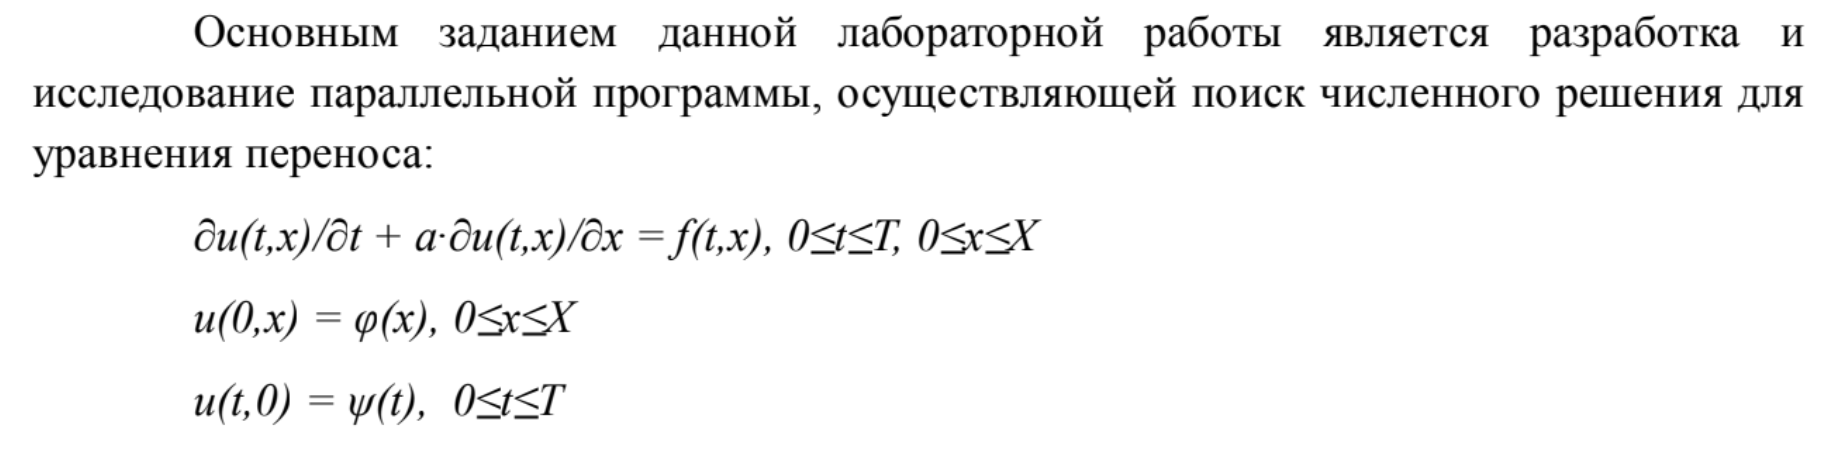
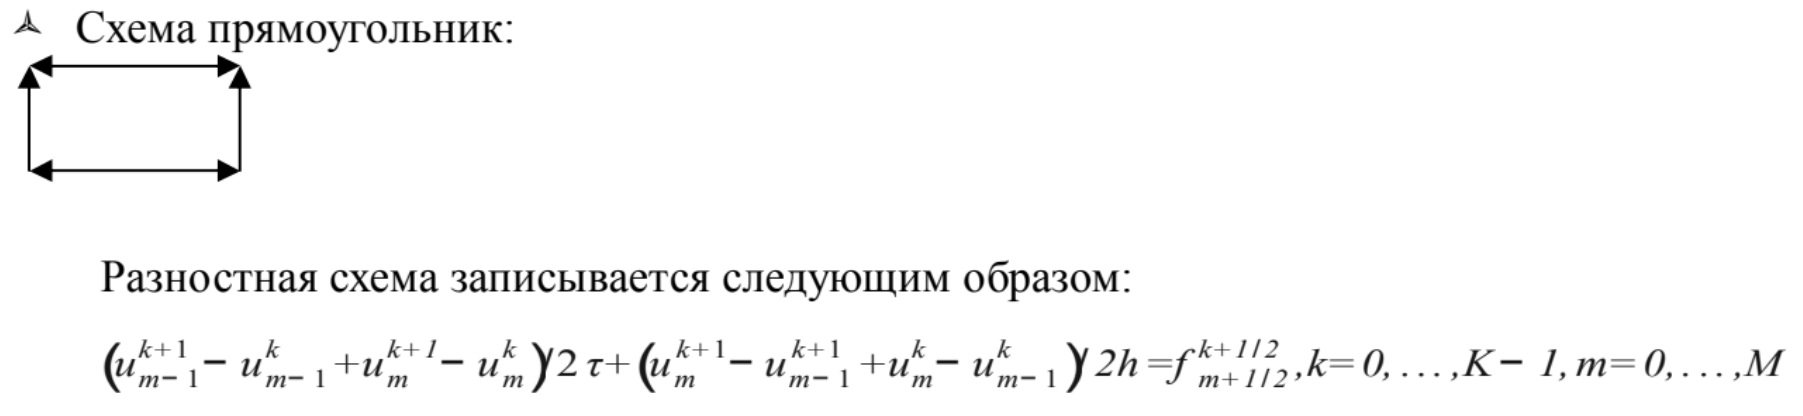

Докажем, что эта схема абсолютно устойчива (устойчива при любых значениях h и T). Для простоты рассмострим частный случай f = 0.   
Воспользуемся спектральным необходимым условием Неймана. Для этого возьмём в качестве начальной функции гармонику $u_n = e^{i\alpha n}$. Тогда $u^j_n = \lambda ^j e^{i\alpha n}$. Подставим это в разностную схему. Получим:   
$$\frac{\lambda^{k + 1}e^{i\alpha (m - 1)} - \lambda^{k}e^{i\alpha (m - 1)} + \lambda^{k + 1}e^{i\alpha m} - \lambda^{k}e^{i\alpha m}}{2\tau} + \frac{\lambda^{k + 1}e^{i\alpha m} - \lambda^{k + 1}e^{i\alpha (m - 1)} + \lambda^{k}e^{i\alpha m} - \lambda^{k}e^{i\alpha (m - 1)}}{2h} = 0$$   
Разделим обе части на $\lambda^{k}e^{i\alpha m}$:   
$$\frac{\lambda e^{-i\alpha} - e^{-i\alpha} + \lambda - 1}{2\tau} + \frac{\lambda - \lambda e^{-i\alpha} + 1 - e^{-i\alpha}}{2h} = 0$$   
Отсюда:   
$$\frac{\lambda - 1}{\lambda + 1} = \frac{\tau}{h} \frac{e^{-i\alpha} - 1}{e^{-i\alpha} + 1} = -i\frac{\tau}{h}\tan(\frac{\alpha}{2})$$   
Следовательно:   
$$\lambda = \frac{2}{1 + i\frac{\tau}{h}\tan(\frac{\alpha}{2})} - 1$$   
Заметим, что $|1 + i\frac{\tau}{h}\tan(\frac{\alpha}{2})| \geq 1 => |\lambda| \leq 2/1 - 1 = 1$ при любом значении h и $\tau$. Значит, метод абсолютно устойчив.

Код реализации метода с использованием распараллеливания по технологии MPI (c++14):   
```c++
#define _USE_MATH_DEFINES

#include <iostream>
#include <functional>
#include <vector>
#include <fstream>
#include <cmath>
#include "mpi.h"

class Equation final
{
private:
	std::function<double(const double, const double)> f;	// x, t
	const double c;
	double t_max;
	double x_max;
	double t_step;
	double x_step;
	std::vector<double> initial_state_x;
	std::vector<double> initial_state_t;
	double time_to_solve{ 0.0 };

	double find_u_ur(const double u_ul, const double u_ll, const double u_lr, const double x_for_f, const double t_for_f) noexcept	//	find u_upper_right using u_upper_left, u_lower_left and u_lower_right
	{
		return (2 * x_step * t_step * f(x_for_f, t_for_f) + x_step * (u_ll - u_ul + u_lr) + t_step * c * (u_ul - u_lr + u_ll)) / (x_step + t_step * c);
	}

public:

	double** solution;
	size_t x_size_solution;
	size_t t_size_solution;

	Equation(const std::function<double(const double, const double)>& func, const double new_c, const double T, const double X, const double step_in_time, const double step_in_x, std::function<double(double)> fi_x, std::function<double(double)> psi_t) noexcept
		: f(func), c(new_c), t_max(T), x_max(X), t_step(step_in_time), x_step(step_in_x)
	{
		x_size_solution = static_cast<size_t>(ceil(x_max / x_step));
		t_size_solution = static_cast<size_t>(ceil(t_max / t_step));

		initial_state_x.resize(x_size_solution);
		for (int i = 0; i < initial_state_x.size(); i++)
		{
			initial_state_x[i] = fi_x(x_step * i);
		}

		initial_state_t.resize(t_size_solution);
		for (int i = 0; i < initial_state_t.size(); i++)
		{
			initial_state_t[i] = psi_t(t_step * i);
		}

		solution = new double* [x_size_solution];
		for (int i = 0; i < x_size_solution; i++)
		{
			solution[i] = new double[t_size_solution];
		}
	}

	~Equation()
	{
		for (int i = 0; i < x_size_solution; i++)
		{
			delete[] solution[i];
		}
		delete[] solution;
	}

	void solve() noexcept
	{
		int commsize, my_rank;
		MPI_Comm_size(MPI_COMM_WORLD, &commsize);
		MPI_Comm_rank(MPI_COMM_WORLD, &my_rank);

		if (commsize == 1)
		{
			//	Start to measure time
			double start_time = MPI_Wtime();

			//	Fill the initial conditions
			for (int i = 0; i < t_size_solution; i++)
			{
				solution[0][i] = initial_state_t[i];
			}

			//	Fill the boundary conditions
			for (int i = 0; i < x_size_solution; i++)
			{
				solution[i][0] = initial_state_x[i];
			}

			for (int i = 1; i < t_size_solution; i++)	//	start from 1st layer in time
			{
				for (int j = 1; j < x_size_solution; j++)	//	start from 1st layer in x
				{
					solution[j][i] = find_u_ur(solution[j - 1][i], solution[j - 1][i - 1], solution[j][i - 1], (j - 0.5) * x_step, (i - 0.5) * t_step);
				}
			}

			//	Finish to measure time
			time_to_solve = MPI_Wtime() - start_time;

			return;
		}

		size_t part_x_size = static_cast<size_t>( ceil( static_cast<double>(x_size_solution) / (commsize - 1) ) );	//  -1 because 0-rank doesn't handle a solution
		
		int last_rank = static_cast<size_t>( ceil( static_cast<double>(x_size_solution) / part_x_size ) );

		//std::cout << "Part_x_size: " << part_x_size << " last_rank: " << last_rank << std::endl;

		//	10, 3  -> 5, 2
		//	10, 4  -> 4, 3
		//	10, 5  -> 2, 5
		//	10, 7  -> 2, 5
		//	10, 8  -> 2, 5
		//	10, 12 -> 1, 10

		if (my_rank == 0)
		{
			//	Start to measure time
			double start_time = MPI_Wtime();

			int x_index = 0;
			MPI_Status status;
			for (int i = 1; i < last_rank; i++)
			{
				for (int j = 0; j < part_x_size; j++)
				{
					MPI_Recv(solution[x_index++], t_size_solution, MPI_DOUBLE, i, 0, MPI_COMM_WORLD, &status);
				}
			}
			int last_process_x_size = part_x_size - (part_x_size * last_rank - x_size_solution);
			for (int j = 0; j < last_process_x_size; j++)
			{
				MPI_Recv(solution[x_index++], t_size_solution, MPI_DOUBLE, last_rank, 0, MPI_COMM_WORLD, &status);
			}

			//	Finish to measure time
			time_to_solve = MPI_Wtime() - start_time;
		}
		else if (my_rank == 1)
		{
			//	Allocate the memory for part os solution
			double** part_solution;		//	first is x, seond is t
			part_solution = new double* [part_x_size];

			for (int i = 0; i < part_x_size; i++)
			{
				part_solution[i] = new double[t_size_solution];
			}

			//	Fill the initial conditions
			for (int i = 0; i < t_size_solution; i++)
			{
				part_solution[0][i] = initial_state_t[i];
			}

			//	Fill the boundary conditions
			for (int i = 0; i < part_x_size; i++)
			{
				part_solution[i][0] = initial_state_x[i];
			}

			for (int i = 1; i < t_size_solution; i++)	//	start from 1st layer in time
			{
				for (int j = 1; j < part_x_size; j++)	//	start from 1st layer in x
				{
					part_solution[j][i] = find_u_ur(part_solution[j - 1][i], part_solution[j - 1][i - 1], part_solution[j][i - 1], (j - 0.5) * x_step, (i - 0.5) * t_step);
				}
				if (commsize > 2)	//	if more than 1 process is engaged in processing (0-the process does not process the solution)
				{
					MPI_Send(&part_solution[part_x_size - 1][i], 1, MPI_DOUBLE, 2, 0, MPI_COMM_WORLD);
				}
			}

			
			for (int i = 0; i < part_x_size; i++)
			{
				MPI_Send(part_solution[i], t_size_solution, MPI_DOUBLE, 0, 0, MPI_COMM_WORLD);
			}
			

			//	Free the memory
			for (int i = 0; i < part_x_size; i++)
			{
				delete[] part_solution[i];
			}
			delete[] part_solution;
		}
		else if (my_rank == last_rank)
		{
			//	Allocate the memory for part os solution
			double** part_solution;
			int part_solution_size = part_x_size - (part_x_size * last_rank - x_size_solution);
			part_solution = new double* [part_solution_size];		//  -1 because 0-rank doesn't handle a solution
			for (int i = 0; i < part_solution_size; i++)
			{
				part_solution[i] = new double[t_size_solution];
			}

			//	Fill the boundary conditions
			for (int i = 0; i < part_solution_size; i++)
			{
				//std::cout << "Vector index in last: " << (last_rank - 1) * part_x_size + i << std::endl;
				part_solution[i][0] = initial_state_x[(last_rank - 1) * part_x_size + i];
			}

			MPI_Status status;

			for (int i = 1; i < t_size_solution; i++)	//	start from 1st layer in time
			{
				MPI_Recv(&part_solution[0][i], 1, MPI_DOUBLE, my_rank - 1, 0, MPI_COMM_WORLD, &status);
				for (int j = 1; j < part_solution_size; j++)	//	start from 1st layer in x
				{
					part_solution[j][i] = find_u_ur(part_solution[j - 1][i], part_solution[j - 1][i - 1], part_solution[j][i - 1], ((last_rank - 1) * part_x_size + j - 0.5) * x_step, (i - 0.5) * t_step);
				}
			}

			for (int i = 0; i < part_solution_size; i++)
			{
				MPI_Send(part_solution[i], t_size_solution, MPI_DOUBLE, 0, 0, MPI_COMM_WORLD);
			}

			//	Free the memory
			for (int i = 0; i < part_solution_size; i++)
			{
				delete[] part_solution[i];
			}
			delete[] part_solution;
		}
		else
		{
			if (my_rank > last_rank)
			{
				return;
			}
			
			//	Allocate the memory for part os solution
			double** part_solution;
			part_solution = new double* [part_x_size];
			for (int i = 0; i < part_x_size; i++)
			{
				part_solution[i] = new double[t_size_solution];
			}

			//	Fill the boundary conditions
			for (int i = 0; i < part_x_size; i++)
			{
				//std::cout << "My rank: " << my_rank << " part_x_size: " << part_x_size << " i: " << i << " vector_size: " << initial_state_x.size() << " Expression: " << (my_rank - 1) * part_x_size + i << std::endl;
				part_solution[i][0] = initial_state_x[(my_rank - 1) * part_x_size + i];
			}

			MPI_Status status;

			for (int i = 1; i < t_size_solution; i++)	//	start from 1st layer in time
			{
				MPI_Recv(&part_solution[0][i], 1, MPI_DOUBLE, my_rank - 1, 0, MPI_COMM_WORLD, &status);
				for (int j = 1; j < part_x_size; j++)	//	start from 1st layer in x
				{
					part_solution[j][i] = find_u_ur(part_solution[j - 1][i], part_solution[j - 1][i - 1], part_solution[j][i - 1], ((my_rank - 1) * part_x_size + j - 0.5) * x_step, (i - 0.5) * t_step);
				}
				MPI_Send(&part_solution[part_x_size - 1][i], 1, MPI_DOUBLE, my_rank + 1, 0, MPI_COMM_WORLD);
			}

			for (int i = 0; i < part_x_size; i++)
			{
				MPI_Send(part_solution[i], t_size_solution, MPI_DOUBLE, 0, 0, MPI_COMM_WORLD);
			}

			//	Free the memory
			for (int i = 0; i < part_x_size; i++)
			{
				delete[] part_solution[i];
			}
			delete[] part_solution;
		}
	}

	double get_last_time_to_solve() const noexcept
	{
		return time_to_solve;
	}
};

int main(int argc, char** argv)
{
	int commsize, my_rank;
	MPI_Init(&argc, &argv);

	auto f = [](const double x, const double t)
	{
		return x + t;
	};

	double c = 1;

	double max_t = 1;
	double max_x = 1;
	double step_t = 0.005;
	double step_x = 0.005;

	auto fi_x = [](const double x)
	{
		return cos(M_PI * x);
	};

	auto psi_t = [](const double t)
	{
		return exp(-t);
	};

	Equation my_equation(f, c, max_t, max_x, step_t, step_x, fi_x, psi_t);
	my_equation.solve();

	MPI_Comm_size(MPI_COMM_WORLD, &commsize);
	MPI_Comm_rank(MPI_COMM_WORLD, &my_rank);

	if (my_rank == 0)
	{
		std::cout << "Solution was found in " << my_equation.get_last_time_to_solve() * 1000 << " ms:" << std::endl;

		std::ofstream output("Output.txt");
		
		output << step_x << " " << step_t << " " << std::endl;
		for (int i = 0; i < my_equation.x_size_solution; i++)
		{
			for (int j = 0; j < my_equation.t_size_solution; j++)
			{
				output << my_equation.solution[i][j] << " ";
			}
			output << std::endl;
		}
		output.close();
	}

	MPI_Finalize();
	return 0;
}
```

Замечание: полное решение уравнения в результате выполнения кода записывается в файл "Output.txt" в директории проекта.

### Сравнение результатов, полученных программой, с аналитическим решением

Для тестов рассмотрим уравнение вида:   
$$\frac{dU(t,x)}{dt} + 2\frac{dU(t,x)}{dx} = x + t$$  
$$U(0,t) = e^{-t}$$
$$U(x,0) = \cos(\pi x)$$
На интервале $x \in (0, 1]$, $t \in (0, 1]$ с шагом $\tau = h = 0.005$:

In [14]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [15]:
def get_data_from_file():
    data_file = open("Output.txt")
    data_list = data_file.readlines()
    data_file.close()
    return data_list

In [16]:
def get_solution_info(data_list):
    solution = []

    for time_line in data_list:
        all_values = time_line.split(' ')
        all_values.pop()  #  delete last '\n'
        solution.append(list(np.asfarray(all_values)))

    steps = solution.pop(0)
    x_step, t_step = steps
    np_sol = np.array(solution)
    return x_step, t_step, np_sol

In [17]:
def get_plot_params(x_step, t_step, np_sol):
    x_size = len(solution)
    t_size = len(solution[0])
    x = []
    t = []
    for i in range(x_size):
        x.append(x_step * i)
    for i in range(t_size):
        t.append(t_step * i)
    xgrid, ygrid = np.meshgrid(t, x)
    return xgrid, ygrid

Решение, полученное численным методом, имеет вид:

In [20]:
def plot():
    data_list = get_data_from_file()
    x_step, t_step, np_sol = get_solution_info(data_list)
    fig = plt.figure(figsize=[12, 4])
    axes = fig.add_subplot(projection='3d')
    x, y = get_plot_params(x_step, t_step, np_sol)
    axes.plot_surface(y, x, np_sol)
    plt.xlabel("x axis")
    plt.ylabel("t axis")
    plt.show()

<IPython.core.display.Javascript object>


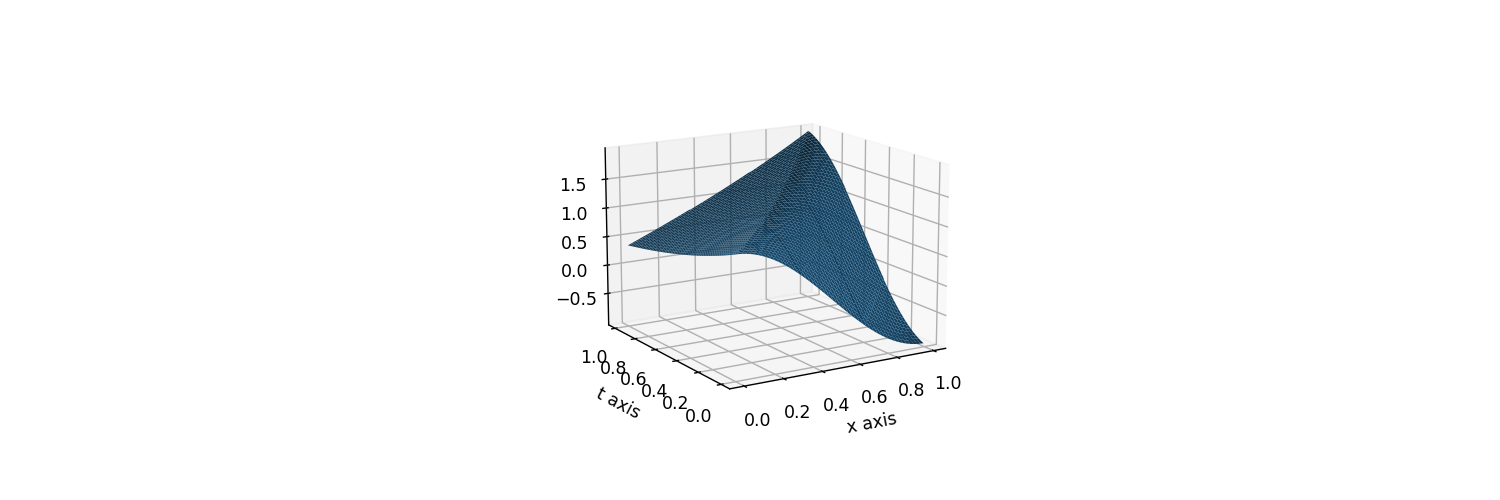

In [21]:
plot()

Решение, полученное аналитически:   
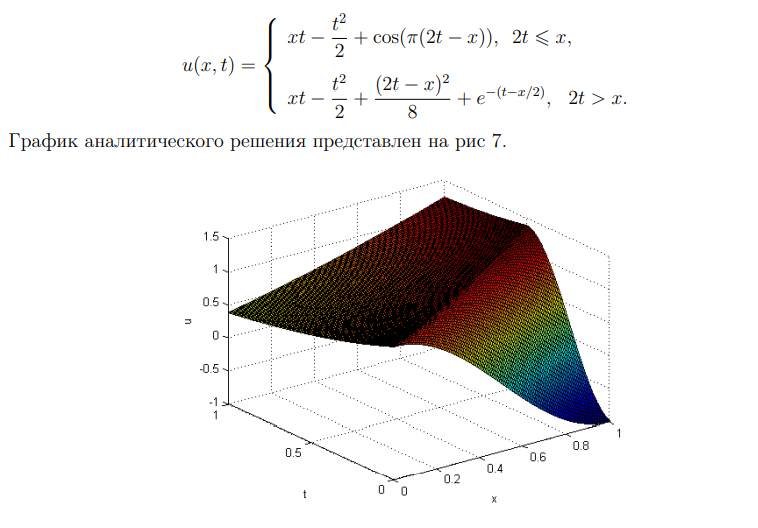

Можно заметитить, что графики решений совпадают.

### Примеры разных начальных данных

1. Тривиальный случай:  
$$\frac{dU(t,x)}{dt} = 0$$
$$U(0,t) = 0$$
$$U(x,0) = 0$$
Решение - горизонтальная плоскость:

<IPython.core.display.Javascript object>


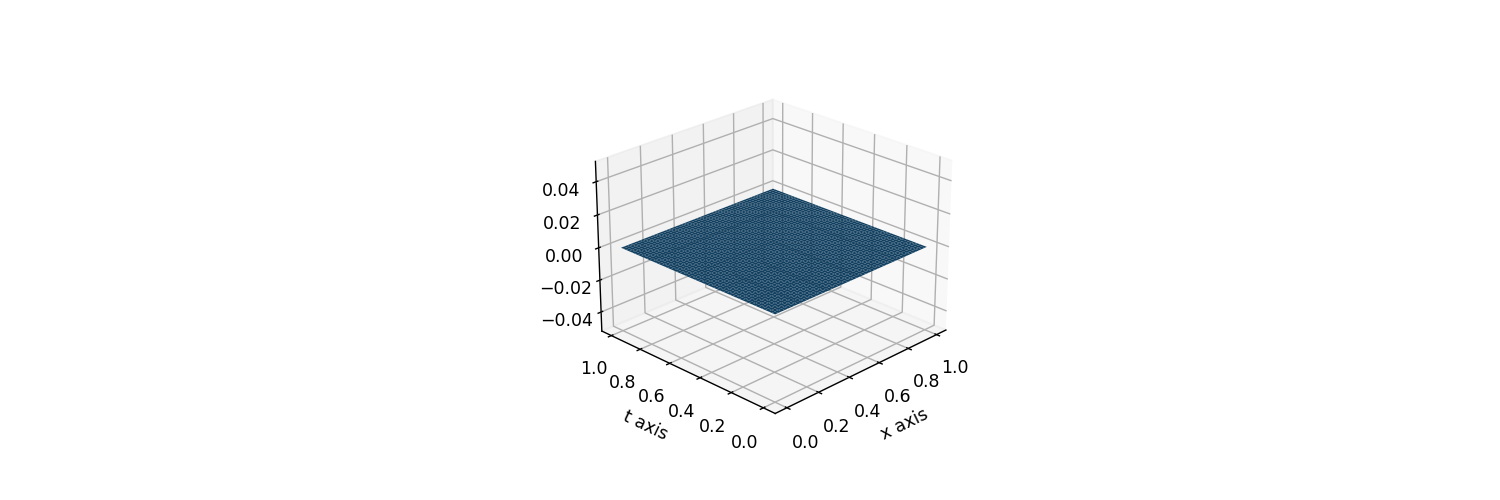

In [22]:
plot()

2. Cлучай простейшего уравнения с дифференциалами 2 переменных:  
$$\frac{dU(t,x)}{dt} + \frac{dU(t,x)}{dx} = 1$$
$$U(0,t) = 0$$
$$U(x,0) = 0$$

<IPython.core.display.Javascript object>


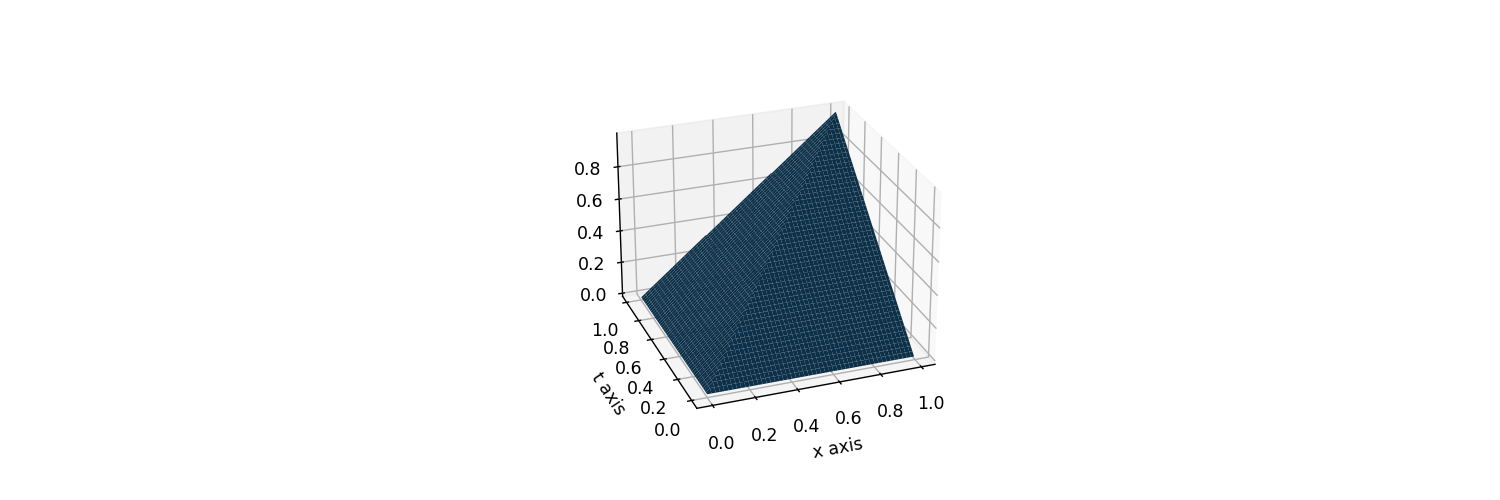

In [27]:
plot()

3. Общий случай уравнения:  
$$\frac{dU(t,x)}{dt} + \frac{dU(t,x)}{dx} = \cos(x) + \cos(t)$$
$$U(0,t) = \sin(t)$$
$$U(x,0) = \sin(2x)$$

<IPython.core.display.Javascript object>


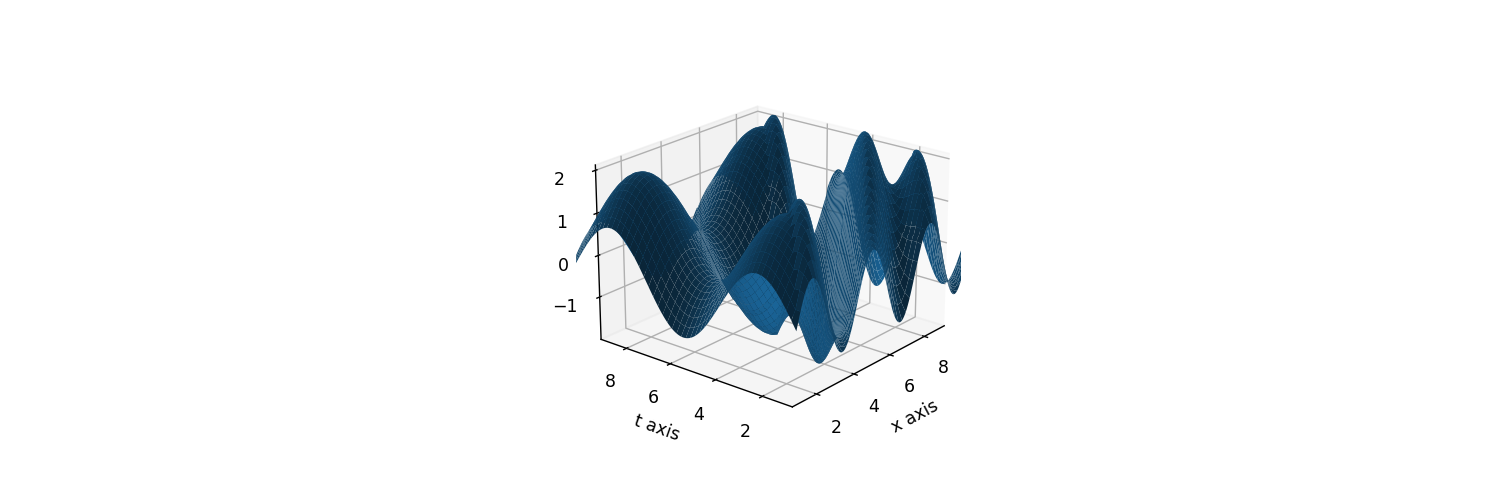

In [31]:
plot()